In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler

/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

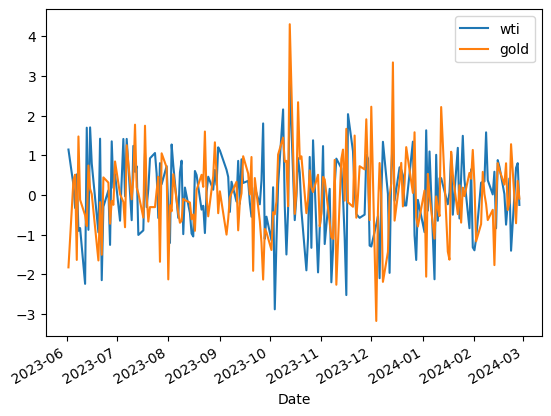

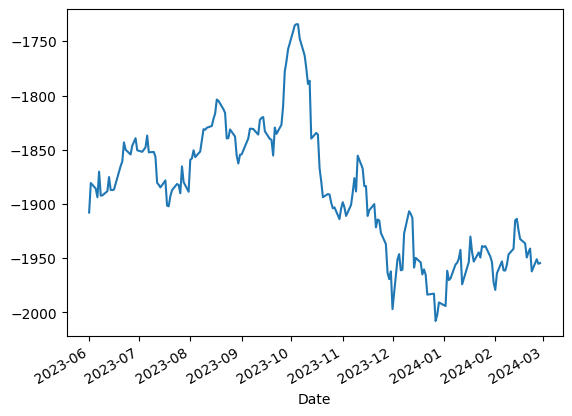

adf            -1.722314
p-value         0.419654
critical 1%    -3.466201
critical 5%    -2.877293
critical 10%   -2.575168
dtype: float64

Cointegration test results:
Test statistic: -14.85961452356393
Critical values: [-3.95596507 -3.36899945 -3.067208  ]


In [12]:
df_cl = yf.download('CL=F', interval='1d', start='2023-06-01', end='2024-02-29')
df_gc = yf.download('GC=F', interval='1d', start='2023-06-01', end='2024-02-29')

# df_cl = df_cl.loc[df_gc.index]

cl_close = df_cl.Close
gc_close = df_gc.Close

cl_diff = cl_close.pct_change().iloc[1:]
gc_diff = gc_close.pct_change().iloc[1:]

df = pd.DataFrame(
    {'wti': StandardScaler().fit_transform(cl_diff.values.reshape(-1, 1)).reshape(-1), 'gold': StandardScaler().fit_transform(gc_diff.values.reshape(-1, 1)).reshape(-1)},
    index=cl_diff.index
).plot()
plt.show()

df = pd.DataFrame(
    {'wti': cl_close.values, 'gold': gc_close.values},
    index=cl_close.index
)

df['diff'] = df['wti'] - df['gold']
df['diff'].plot()
plt.show()

result = adfuller(df['diff'], autolag='AIC')
data = {
    'adf': result[0],
    'p-value': result[1],
}
for key, value in result[4].items():
        data[f'critical {key}'] = value

print(pd.Series(data))

test = coint(cl_diff, gc_diff)
print("\nCointegration test results:")
print("Test statistic:", test[0])
print("Critical values:", test[2])

- Since the test statistic is significantly lower (in absolute terms) than all of the critical values, it falls into the rejection region for all levels of significance. This suggests strong evidence against the null hypothesis of no cointegration.
- In other words, there is a statistically significant long-term relationship between crude oil futures and gold futures.
- The negative test statistic indicates a negative relationship between the two assets. This implies that when one asset's price increases, the other asset's price tends to decrease, and vice versa.

In [36]:
res_coint = coint_johansen(pd.DataFrame([cl_diff.values, gc_diff.values]).T, 0, 1)
trace_stats = res_coint.lr1
eigen_stats = res_coint.lr2

print(f'Trace:\n{trace_stats}\n')
print(f'Eigen:\n{eigen_stats}\n')
print(f'Critical Values:\n{res_coint.cvt}')

Trace:
[160.8221026   76.09753813]

Eigen:
[84.72456447 76.09753813]

Critical Values:
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [37]:
coint(cl_diff, gc_diff)

(-14.85961452356393,
 1.4903403715751072e-26,
 array([-3.95596507, -3.36899945, -3.067208  ]))